In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

## Windows 11 --> MacOS Transfer
If you initially developed any code on a windows laptop and then cloned said repository with code in a macbook here are some steps you may need to take...
1. navigate to your project directory: cd ferc_data_project
2. create a virtual environment, here is where we will be adding packages: python -m venv venv
3. activate the virtual environment: source venv/bin/activate
4. now you can install packages into the environment so that code will run!

In [27]:
class PolarsTechnicalIndicators:

    def __init__(self, df):
        self.df = df

    def calculate_smaBB(self, x):
        # Calculate SMA
        sma = self.df['wti'].rolling_mean(window_size=x).alias('sma')

        # Calculate rolling std for Bollinger Bands
        rolling_std = self.df['wti'].rolling_std(window_size=x).alias('stdsma')

        # Add SMA, rolling standard deviation, and Bollinger Bands based on SMA
        self.df = self.df.with_columns([
            sma,
            rolling_std,
            (sma + 2 * rolling_std).alias('sma_bb_upper'),
            (sma - 2 * rolling_std).alias('sma_bb_lower')
        ])

        return self.df

    def calculate_emaBB(self, x):
        # Calculate EMA
        self.df=self.df.with_columns(self.df['wti'].ewm_mean(span=x, adjust=False).alias('ema'))

        # Calculate rolling std for ema
        self.df= self.df.with_columns(self.df['ema'].ewm_std(span=x).alias('stdema'))

        # Add Bollinger Bands based on ema rolling std
        self.df = self.df.with_columns(
        (self.df['ema'] + 2 * self.df['stdema']).alias('ema_bb_upper'),
        (self.df['ema'] - 2 * self.df['stdema']).alias('ema_bb_lower')
        )

        return self.df


    def calculate_roc(self, x):
        #calculate ROC
        self.df = self.df.with_columns(self.df["wti"].pct_change(x).shift(x).alias('roc'))
        
        return self.df

In [13]:
# loading in wti and henry hub data
data = pl.read_csv('commodity_benchmark_volatility.csv')
data.describe()

statistic,period,wti,hh
str,str,f64,f64
"""count""","""471""",471.0,339.0
"""null_count""","""0""",0.0,132.0
"""mean""",null,47.801019,4.122743
"""std""",null,29.540756,2.138153
"""min""","""Apr-00""",11.35,1.49
"""25%""",null,20.19,2.58
"""50%""",null,40.78,3.45
"""75%""",null,71.58,5.24
"""max""","""Sep-99""",133.88,13.42


In [14]:
# converting period in to a datetime
data = data.with_columns(
    pl.col('period').str.strptime(pl.Date, format="%b-%y").alias('period_dt')
)

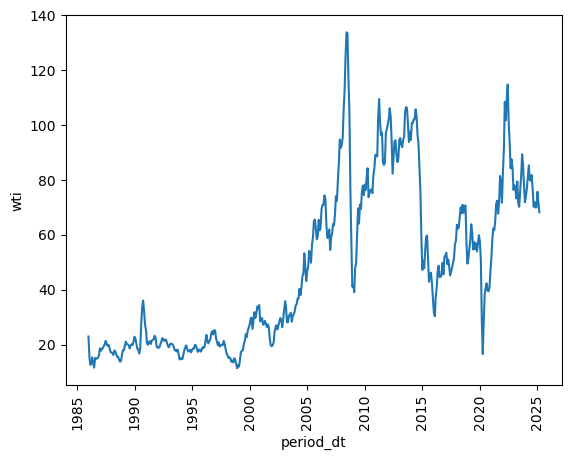

In [15]:
# showing wti prices
plt.figure()

sns.lineplot(data=data, x='period_dt', y='wti')

plt.xticks(rotation=90)

plt.show()

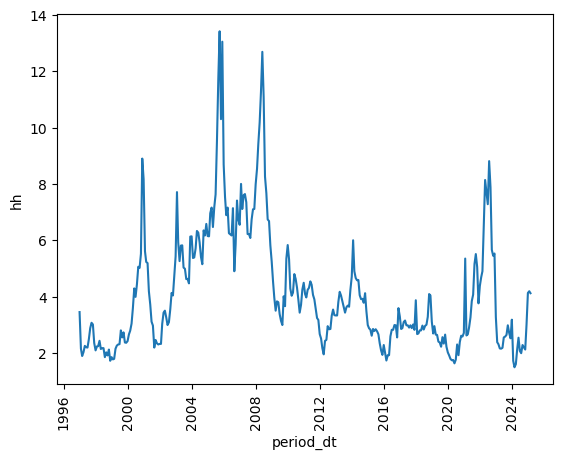

In [16]:
# showing henry hub prices
plt.figure()

sns.lineplot(data=data, x='period_dt', y='hh')

plt.xticks(rotation=90)

plt.show()

In [ ]:
# calculating rolling 12 month standard deviation for wti
wti_data = data.select(['period_dt', 'wti'])
wti_data.with_columns(
    rolling_std = pl.col("wti").rolling_std(window_size=2)
)
wti_data.describe()


statistic,period_dt,wti
str,str,f64
"""count""","""471""",471.0
"""null_count""","""0""",0.0
"""mean""","""2005-07-31 23:44:42.802000""",47.801019
"""std""",null,29.540756
"""min""","""1986-01-01""",11.35
"""25%""","""1995-11-01""",20.19
"""50%""","""2005-08-01""",40.78
"""75%""","""2015-06-01""",71.58
"""max""","""2025-03-01""",133.88


In [45]:
def Process_dataset(dataframe):    
    Class = PolarsTechnicalIndicators(dataframe)
    
    dataframe = Class.calculate_smaBB(x=2)
    dataframe = Class.calculate_emaBB(x=2)
    dataframe = Class.calculate_roc(x=2)
    

    return dataframe


wti_dataset = Process_dataset(wti_data) # see below for link to spy dataset 

wti_dataset.describe()

statistic,period_dt,wti,sma,stdsma,sma_bb_upper,sma_bb_lower,ema,stdema,ema_bb_upper,ema_bb_lower,roc
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""471""",471.0,470.0,470.0,470.0,470.0,471.0,471.0,471.0,471.0,467.0
"""null_count""","""0""",0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0
"""mean""","""2005-07-31 23:44:42.802000""",47.801019,47.805734,2.22027,52.246274,43.365194,47.852066,2.645186,53.142437,42.561694,0.004764
"""std""",null,29.540756,29.459662,2.47805,32.079967,27.490815,29.360302,2.79169,32.890781,26.544291,0.175637
"""min""","""1986-01-01""",11.35,11.935,0.007071,12.986249,4.976056,11.817955,0.0,14.240391,3.444099,-0.567998
"""25%""","""1995-11-01""",20.19,20.26,0.622254,21.890437,18.864045,20.232667,0.879415,22.089119,18.746655,-0.082905
"""50%""","""2005-08-01""",40.78,40.985,1.315219,44.817519,36.115887,41.575054,1.78118,47.774852,33.952571,-0.016136
"""75%""","""2015-06-01""",71.58,71.115,2.906209,77.215929,65.390496,71.475192,3.412434,78.717519,65.226902,0.060765
"""max""","""2025-03-01""",133.88,133.625,19.445436,148.637366,132.903751,130.948541,21.743414,167.146151,109.355922,2.053776


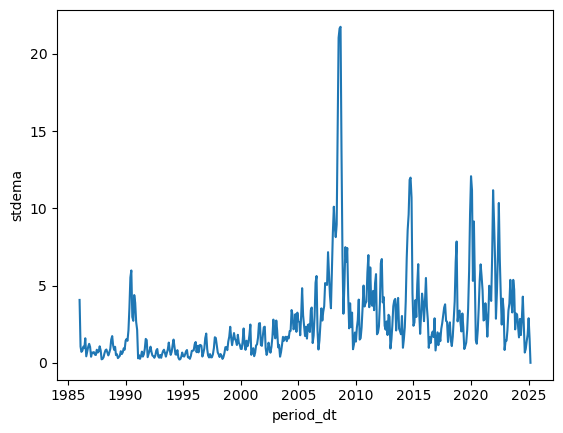

In [46]:
plt.figure()

sns.lineplot(data=wti_dataset, x='period_dt', y='stdema')

plt.show()